# Bayesian inference of parameters

In [1]:
import numpy as np
import os
from scipy.optimize import minimize
from model import NeoHookeanSolutionGenerator

"""
Note!

We use two versions of the DRAM algorithm here.

The one in the textbook only works for non-informative priors, which I implemented
in the file called DRAM.py

To work for informative priors (as requested in the project handout), we turn to
an external implementation.

If the textbook had a version for the informative priors I would have implemented
it. But alas, that is not the case.
"""
from DRAM import DRAMParameters, DRAM

try:
    from pymcmcstat.MCMC import MCMC
except ImportError:
    raise RuntimeError(
        "I have only implemented the uninformative prior version of DRAM found in the textbook. For the informative prior version, please install pymcmcstat"
    )

from matplotlib import pyplot as plt

import seaborn as sns

%matplotlib inline

sns.set_theme(style="white")

from scipy.stats import gaussian_kde, norm, uniform
from statsmodels.tsa.stattools import acf
from matplotlib.colors import to_rgb
import pandas as pd

## Signals from experiments for model calibration

In [2]:
experimental_signal = np.loadtxt(fname='profiles_production.csv', delimiter=",")

## Setup for inference

### Fixed parameters from experiments

In [3]:
# These are fixed, see synthetic_data
omega_val = np.pi
L_val = 2.0
zeta_val = 0.5
nu_f_val = 0.125
# V_wall_val = 1.0

offset = 0.0
res_t = 20
# time stations
time_samples = np.linspace(
    0 + offset / omega_val, (2 * np.pi) / omega_val, res_t, endpoint=False
)
# number of data points
n_samples = len(time_samples)
# y stations
y_stations = np.array([0.2, 0.4, 0.6, 0.8])


In [4]:
# Solution generator
solution_generator = NeoHookeanSolutionGenerator(omega_val, L_val, zeta_val, nu_f_val)

### Computation of residuals given experimental data

In [5]:
def generate_signal(
    fluid_velocity_gen, solid_velocity_gen, T=time_samples, y_stations=y_stations
):
    y_profiles = np.zeros((len(y_stations), len(T)))

    for i_station, y_station in enumerate(y_stations):
        solid_velocity = solid_velocity_gen(y_station, T)
        fluid_velocity = fluid_velocity_gen(y_station, T)
        solid_mask = y_station < 0.5
        y_profiles[i_station] = (
            solid_mask * solid_velocity + (1.0 - solid_mask) * fluid_velocity
        )

    return y_profiles


def signal_from_(estimates):
    global solution_generator
    v_f, v_s = solution_generator.generate_velocities_for(*estimates)
    signal = generate_signal(v_f, v_s)
    return signal


def residuals_given(estimates, exp_data=experimental_signal):
    # global experimental_signal
    model_signal = signal_from_(estimates)
    # return np.sum(np.linalg.norm(results - y_eval.T, 2, axis=1)**2)
    return np.linalg.norm(model_signal - exp_data, 2)

### Initial estimates of uncertainty by repeatedly solving a local least square problem

In [6]:
# (c1_val, V_wall_val, nu_s_val)
# estimates = [0.0625, 1.0, 0.01]

parameter_keys = ["c_1", "V_wall", "nu_s"]
n_params = len(parameter_keys)

estimates = {"c_1": 0.0525, "V_wall": 1.0, "nu_s": 0.005}
sigma_estimates = {"c_1": 0.02, "V_wall": 0.02} # , "nu_s": 0.002}

# These bounds come from domain knowledge
bounds_on_estimates = {
    "c_1": (0.00625, 0.625),
    "V_wall": (0.9, 1.1),
    "nu_s": (0.0, 0.04),
}

lstsq_result = minimize(
    residuals_given, list(estimates.values()), bounds=list(bounds_on_estimates.values())
)  # , tol=1e-5, options={'maxiter' : 5000}

In [7]:
lstsq_estimates = dict(zip(parameter_keys, lstsq_result.x))
print("Least square optimized estimates" , lstsq_estimates)
lstsq_sos_error = residuals_given(lstsq_result.x)**2
print("Least square optimized residual sum of squares", lstsq_sos_error)
lstsq_variance_estimate = lstsq_sos_error / (n_samples - n_params)
print("Estimate for the variance in residuals", lstsq_variance_estimate)
print("Estimate for the stddev in residuals", np.sqrt(lstsq_variance_estimate))

Least square optimized estimates {'c_1': 0.06466916945871642, 'V_wall': 0.9977529873336859, 'nu_s': 0.010511603939026164}
Least square optimized residual sum of squares 0.2705111435912181
Estimate for the variance in residuals 0.015912420211248123
Estimate for the stddev in residuals 0.1261444418563423


In [8]:
# Initial covariance matrix estimate
chi_f, chi_s = solution_generator.generate_sensitivities_for(*lstsq_result.x)

# we have multiple measurement points, so pool that in the first dimension
sensitivity_matrix = np.zeros((len(y_stations) * n_samples, n_params))

for i_station, y_station in enumerate(y_stations):
    solid_sens = chi_s(y_station, time_samples).squeeze().T  # (len(T), 3)
    fluid_sens = chi_f(y_station, time_samples).squeeze().T  # (len(T), 3)
    solid_mask = y_station < 0.5
    sensitivity_matrix[i_station * n_samples : (i_station + 1) * n_samples] = (
        solid_mask * solid_sens + (1.0 - solid_mask) * fluid_sens
    )

In [9]:
fischer = sensitivity_matrix.T @ sensitivity_matrix
fischer_inv = np.linalg.inv(fischer)

# can use estimated variance here too
lstsq_covariance = lstsq_variance_estimate * fischer_inv
lstsq_covariance

array([[ 1.74716232e-05, -1.13697646e-04, -1.92484735e-06],
       [-1.13697646e-04,  4.71768481e-03,  7.98681714e-05],
       [-1.92484735e-06,  7.98681714e-05,  7.32257237e-06]])

In [10]:
def cov2corr(A):
    """
    covariance matrix to correlation matrix.
    """
    d = np.sqrt(A.diagonal())
    cor = ((A.T / d).T) / d
    return cor


cov2corr(lstsq_covariance)

array([[ 1.        , -0.39602298, -0.17017581],
       [-0.39602298,  1.        ,  0.42971196],
       [-0.17017581,  0.42971196,  1.        ]])

### Run DRAM for Bayesian inference

In [11]:
def custom_sos_function(theta, data):
    # Custom sum of squares function to play nice with our algorithm
    # time_points = data.xdata[0]
    experimental_signal = data.ydata[0]
    return residuals_given(theta, experimental_signal)

In [12]:
mcstat = MCMC(rngseed=1234)

n_simulations = int(4e4)
mcstat.data.add_data_set(time_samples, experimental_signal)

mcstat.simulation_options.define_simulation_options(
    nsimu=n_simulations, updatesigma=True, method="dram", qcov=lstsq_covariance
)

mcstat.model_settings.define_model_settings(sos_function=custom_sos_function)

# initial_d1, initial_k2, initial_delta, initial_b_E = estimates

for key in ["c_1", "V_wall"]:
    mcstat.parameters.add_model_parameter(
        name=key,
        theta0=lstsq_estimates[key],
        minimum=bounds_on_estimates[key][0],
        maximum=bounds_on_estimates[key][1],
        prior_mu=lstsq_estimates[key],
        prior_sigma=sigma_estimates[key],
        sample=True,
    )

key = "nu_s"
mcstat.parameters.add_model_parameter(
    name=key,
    theta0=lstsq_estimates[key],
    minimum=0.003,
    maximum=0.03,
    # minimum=bounds_on_estimates[key][0],
    # maximum=bounds_on_estimates[key][1],
    sample=True,
)
    
# run mcmc
mcstat.run_simulation()


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
       c_1:      0.06 [ 6.25e-03,      0.62] N(     0.06,     0.02^2)
    V_wall:      1.00 [     0.90,      1.10] N(     1.00,     0.02^2)
      nu_s:      0.01 [ 3.00e-03,      0.03] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 40000 of 40000 complete in 186.7 sec

In [13]:
# # Rerun starting from results of previous run
# mcstat.simulation_options.nsimu = int(1e4)
# mcstat.run_simulation(use_previous_results=True)

In [14]:
results = mcstat.simulation_results.results
chain = results['chain']
s2chain = results['s2chain']

# define burnin
burnin = 2000
# display chain statistics
burntin_chain = chain[burnin:, :]
mcstat.chainstats(burntin_chain, results)
print('chain[-1, :] = {}'.format(chain[-1, :]))



------------------------------
      name:      mean       std    MC_err       tau    geweke
       c_1:      0.06      0.01  2.54e-04     11.45      0.97
    V_wall:      1.00      0.02  3.49e-04     11.03      1.00
      nu_s:      0.02  7.36e-03  1.26e-04     10.45      0.95
------------------------------
Acceptance rate information
---------------
Results dictionary:
Stage 1: 29.23%
Stage 2: 53.25%
Net    : 82.48% -> 32994/40000
---------------
Chain provided:
Net    : 82.47% -> 31337/38000
---------------
Note, the net acceptance rate from the results dictionary
may be different if you only provided a subset of the chain,
e.g., removed the first part for burnin-in.
------------------------------
chain[-1, :] = [0.10041042 1.02574882 0.00766359]


### Obtain DRAM statistical estimates

In [15]:
dram_profiles = np.zeros((len(y_stations), n_samples))

def sample_mean_cov(samples):
    k_sample_history_arr = np.array(samples)
    k_samples = k_sample_history_arr.shape[0]
    # print(curr, k_samples, self.params.k_0)
    # assert k_samples == self.params.k_0
    mean_k_samples = np.mean(k_sample_history_arr, axis=0)
    # sp cov(q0, q1, ... qk) # (k + 1 entities)
    cov_k_samples = (
        1.0
        / (k_samples - 1)
        * (
            k_sample_history_arr.T @ k_sample_history_arr
            - (k_samples * np.outer(mean_k_samples, mean_k_samples))
        )
    )
    return mean_k_samples, cov_k_samples

dram_mean_estimates, dram_covariance_estimates = sample_mean_cov(burntin_chain) #np.mean(burntin_chain, 0)
dram_variance_estimates = (np.diag(dram_covariance_estimates))

dram_v_f, dram_v_s = solution_generator.generate_velocities_for(*dram_mean_estimates)

for i_station, y_station in enumerate(y_stations):
    solid_velocity = dram_v_s(y_station, time_samples)
    fluid_velocity = dram_v_f(y_station, time_samples)
    solid_mask = y_station < 0.5
    dram_profiles[i_station] = (
        solid_mask * solid_velocity + (1.0 - solid_mask) * fluid_velocity
    )

In [16]:
print("DRAM mean estimates for the parameters are", dict(zip(parameter_keys, dram_mean_estimates)))
print("DRAM var. estimates for the parameters are", dict(zip(parameter_keys, dram_variance_estimates)))
print("DRAM covariance estimate", dram_covariance_estimates)
cov2corr(dram_covariance_estimates)
# print("DRAM error variance estimate", 0.1 * np.mean(s2chain[burnin:]))

DRAM mean estimates for the parameters are {'c_1': 0.06320854363990704, 'V_wall': 0.998053141705539, 'nu_s': 0.016043193213363893}
DRAM var. estimates for the parameters are {'c_1': 0.00022088607951544907, 'V_wall': 0.0003989421789172442, 'nu_s': 5.4180061767687176e-05}
DRAM covariance estimate [[ 2.20886080e-04  3.60542092e-07  3.03093470e-06]
 [ 3.60542092e-07  3.98942179e-04 -6.03673712e-07]
 [ 3.03093470e-06 -6.03673712e-07  5.41800618e-05]]


array([[ 1.        ,  0.00121455,  0.02770593],
       [ 0.00121455,  1.        , -0.00410608],
       [ 0.02770593, -0.00410608,  1.        ]])

### Plot DRAM predictions versus data

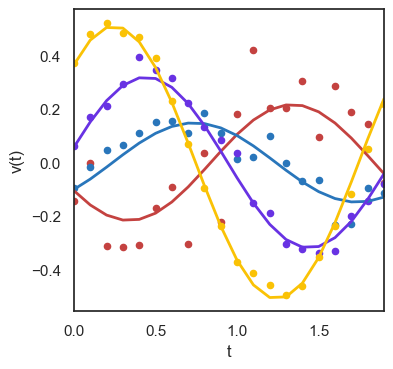

In [17]:
station_colors = [
    to_rgb("xkcd:reddish"),
    to_rgb("xkcd:bluish"),
    to_rgb("xkcd:burple"),
    to_rgb("xkcd:goldenrod"),
]

production = False
dpi = 400 if production else 100

new_f, new_ax = plt.subplots(figsize=(4, 4), dpi=dpi)
new_ax.set_xlim([0.0, 1.9])
new_ax.set_xlabel("t")
new_ax.set_ylabel("v(t)")
for i_profile, dram_profile in enumerate(dram_profiles):
    # axis_idx = ((i_profile // 2), (i_profile % 2))
    # axis_idx = i_profile
    new_ax.plot(
        time_samples,
        dram_profile,
        c=station_colors[i_profile],
        lw=2,
        label="DRAM Model",
    )
    new_ax.scatter(
        time_samples,
        experimental_signal[i_profile],
        color=station_colors[i_profile],
        # lw=2,
        s=20,
        label="Data",
    )
    # new_ax[axis_idx].legend()
# new_ax.legend()
# new_ax.set_title("Reconstructed marginal distribution of h")
if production:
    new_f.savefig("dram_predictions.pdf", bbox_inches="tight")

In [18]:
if False:
    for i_profile, dram_profile in enumerate(dram_profiles):
        np.savetxt(
            f"dram_predicted_profiles_{i_profile}.csv",
            np.c_[time_samples, dram_profile],
            delimiter=",",
        )

### Chain convergence

In [19]:
# Chain is (n_samples, p)
data = dict(zip(parameter_keys, burntin_chain.T))
colors = dict(
    zip(
        parameter_keys,
        [to_rgb("xkcd:reddish"), to_rgb("xkcd:bluish"), to_rgb("xkcd:burple")],
    )
)
chains = pd.DataFrame(data=data)

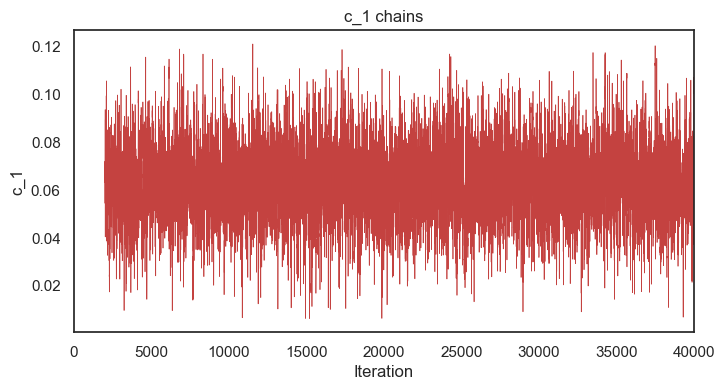

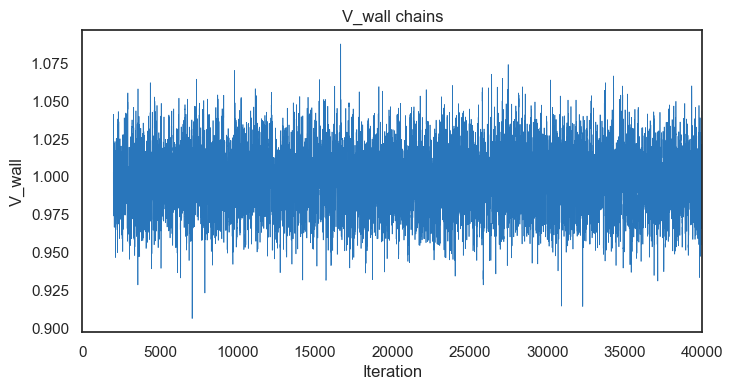

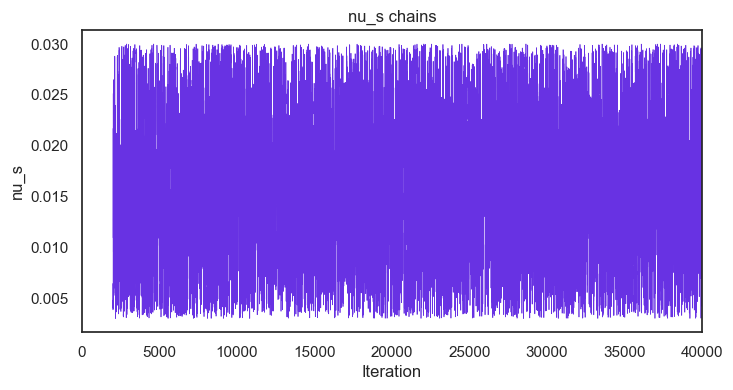

In [20]:
# n_simulations = int(2e4) 
simulation_idx = np.arange(burnin, n_simulations)
for plot_key in chains.keys():
    new_f, new_ax = plt.subplots(figsize=(8, 4), dpi=100)
    new_ax.plot(simulation_idx, chains[plot_key], lw=0.5, c=colors[plot_key])

    key_str = plot_key.__str__()
    new_ax.set_xlabel("Iteration")
    new_ax.set_ylabel(key_str)
    new_ax.set_xlim([0, n_simulations])
    new_ax.set_title("{} chains".format(key_str))

    if False:
        new_f.savefig("bayesian_{}_samples.pdf".format(key_str), bbox_inches="tight")

### Autocorrelation

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warn

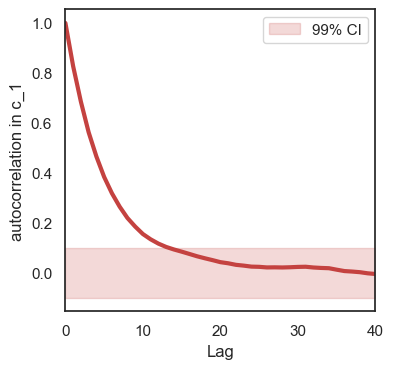

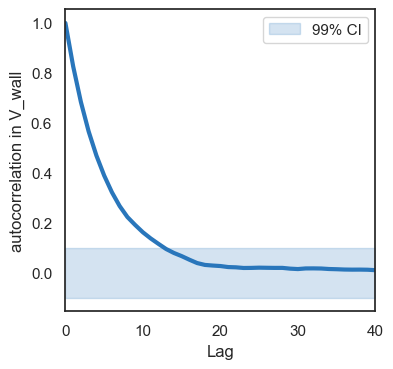

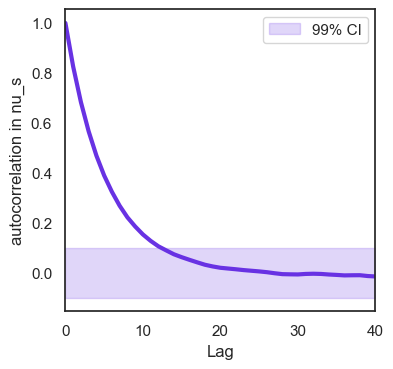

In [21]:
for plot_key in chains.keys():
    new_f, new_ax = plt.subplots(figsize=(4, 4), dpi=100)
    apc = acf(chains[plot_key])
    new_ax.plot(apc, lw=3, c=colors[plot_key])
    new_ax.fill_between(np.arange(0, apc.size), 0.1, -0.1, alpha=0.2, label="99% CI", color=colors[plot_key])

    key_str = plot_key.__str__()
    new_ax.set_xlabel("Lag")
    new_ax.set_ylabel(f"autocorrelation in {key_str}")
    new_ax.set_xlim([0, 40])
    new_ax.legend()

    if False:
        new_f.savefig("bayesian_{}_autocor.pdf".format(key_str), bbox_inches="tight")

### Marginal Distributions

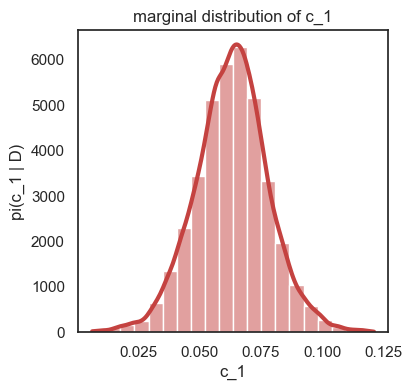

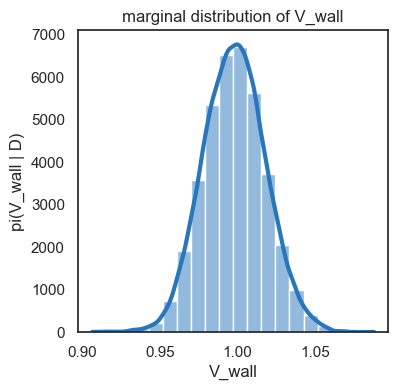

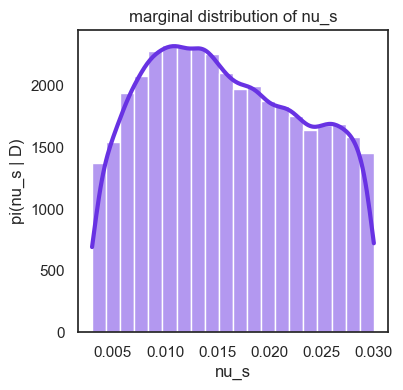

In [22]:
# plot_key = delta

for plot_key in chains.keys():
    new_f, new_ax = plt.subplots(figsize=(4, 4), dpi=100)
    sns.histplot(
        data=chains, x=plot_key, kde=True, ax=new_ax, bins=20, legend=False, color=colors[plot_key]
    )  
    key_str = plot_key.__str__()
    new_ax.lines[0].set_linewidth(3)
    # new_ax.set_xlabel("h")
    new_ax.set_ylabel("pi({} | D)".format(key_str))
    new_ax.set_title("marginal distribution of {}".format(key_str))

    if False:
        new_f.savefig("bayesian_{}_marginals.pdf".format(key_str), bbox_inches="tight")

### Marginals with priors, posteriors and target distributions

0.9999999599352918


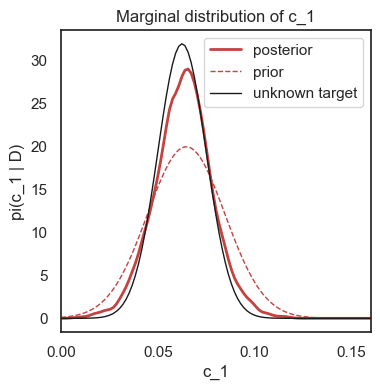

In [23]:
production = False
dpi = 400 if production else 100

key_str = "c_1"
p = gaussian_kde(chains[key_str])
x = np.linspace(0.0, 0.16, 101)
print(p.integrate_box_1d(0.0, 0.2))
new_f, new_ax = plt.subplots(figsize=(4, 4), dpi=dpi)
# posterior
new_ax.plot(x, p(x), c=colors[key_str], lw=2, label="posterior")

# prior
rv = norm(lstsq_estimates[key_str], sigma_estimates[key_str])
new_ax.plot(x, rv.pdf(x), c=colors[key_str], lw=1, linestyle="--", label="prior")

# target distribution
target_rv = norm(0.0625, 0.0125)
new_ax.plot(x, target_rv.pdf(x), c='k', lw=1, label="unknown target")

new_ax.set_ylabel("pi({} | D)".format(key_str))
new_ax.set_xlabel(key_str)
new_ax.set_title("Marginal distribution of {}".format(key_str))
new_ax.set_xlim(x[0], x[-1])
new_ax.legend()

if production:
    new_f.savefig("bayesian_{}_marginals_with_posterior.pdf".format(key_str), bbox_inches="tight")

0.9999998855166479


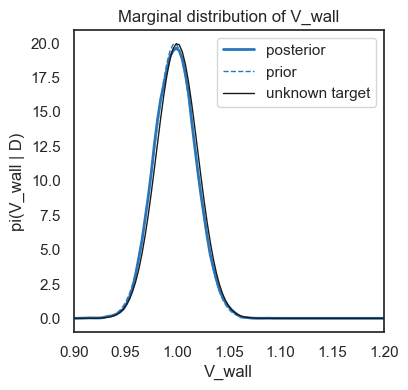

In [24]:
key_str = "V_wall"
p = gaussian_kde(chains[key_str])
x = np.linspace(0.9, 1.2, 101)
print(p.integrate_box_1d(0.9, 1.1))
new_f, new_ax = plt.subplots(figsize=(4, 4), dpi=dpi)
# posterior
new_ax.plot(x, p(x), c=colors[key_str], lw=2, label="posterior")

# prior
rv = norm(lstsq_estimates[key_str], sigma_estimates[key_str])
new_ax.plot(x, rv.pdf(x), c=colors[key_str], lw=1, linestyle="--", label="prior")

# target distribution
target_rv = norm(1.0, 0.02)
new_ax.plot(x, target_rv.pdf(x), c='k', lw=1, label="unknown target")

new_ax.set_ylabel("pi({} | D)".format(key_str))
new_ax.set_xlabel(key_str)
new_ax.set_title("Marginal distribution of {}".format(key_str))
new_ax.set_xlim(x[0], x[-1])
new_ax.legend()

if production:
    new_f.savefig("bayesian_{}__marginals_with_posterior.pdf".format(key_str), bbox_inches="tight")

0.9999976534694595


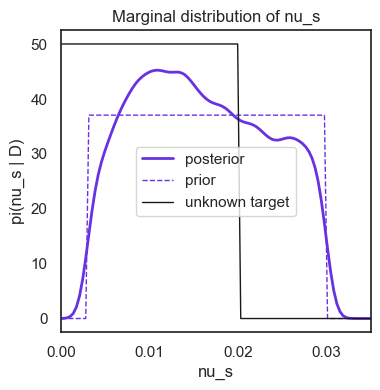

In [25]:
key_str = "nu_s"
p = gaussian_kde(chains[key_str])
x = np.linspace(0.0, 0.035, 101)
print(p.integrate_box_1d(0.0, 0.035))
new_f, new_ax = plt.subplots(figsize=(4, 4), dpi=dpi)
# posterior
new_ax.plot(x, p(x), c=colors[key_str], lw=2, label="posterior")

# prior
loc = 0.003
scale = 0.03 - loc
rv = uniform(loc, scale)
new_ax.plot(x, rv.pdf(x), c=colors[key_str], lw=1, linestyle="--", label="prior")

# target distribution
target_rv = uniform(0.0, 0.02)
new_ax.plot(x, target_rv.pdf(x), c='k', lw=1, label="unknown target")

new_ax.set_ylabel("pi({} | D)".format(key_str))
new_ax.set_xlabel(key_str)
new_ax.set_title("Marginal distribution of {}".format(key_str))
new_ax.set_xlim(x[0], x[-1])
new_ax.legend()

if production:
    new_f.savefig("bayesian_{}__marginals_with_posterior.pdf".format(key_str), bbox_inches="tight")

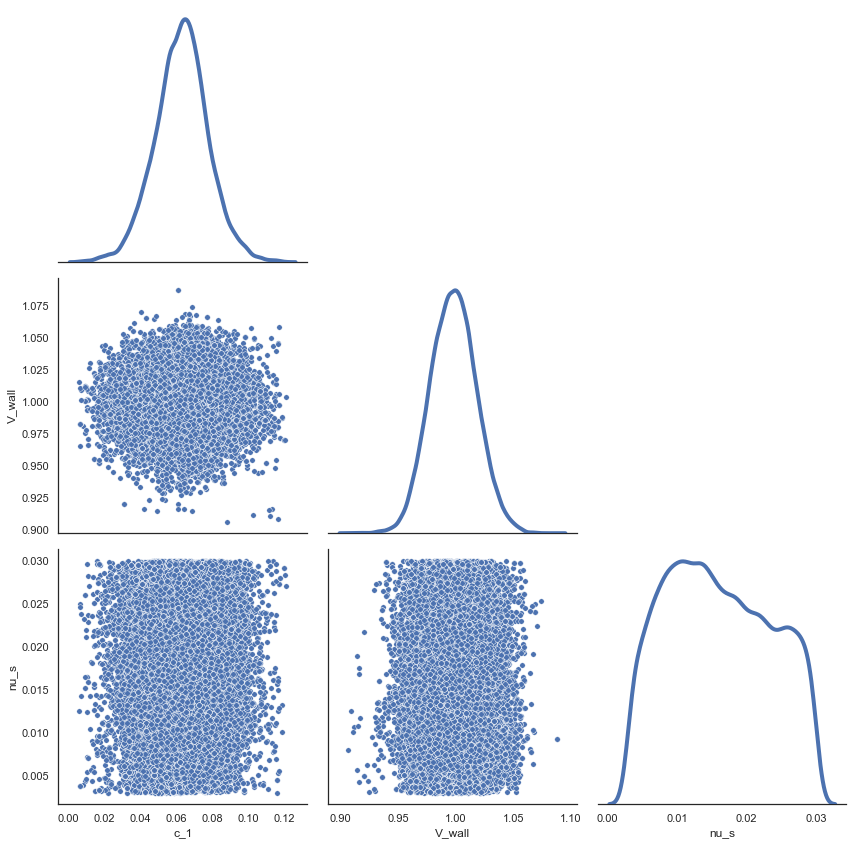

In [26]:
# new_f, new_ax = plt.subplots(figsize=(4, 4), dpi=100)
g = sns.PairGrid(chains, diag_sharey=False, corner=True, height=4)
g.map_lower(sns.scatterplot, s=30)
# g.map_upper(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=4)
if False:
    g.savefig("pairplots.png", dpi=300, bbox_inches="tight")

### Export data for post-processing

In [ ]:
s2chains_df = pd.DataFrame(data=s2chain)

In [ ]:
chains.to_pickle("chains.pkl")
s2chains_df.to_pickle("s2chains.pkl")

## Using my uninformative prior DRAM algorithm

In [ ]:
params = DRAMParameters(M=int(4e3), k_0 = 100, n_s=0.01)
dram = DRAM(params)
print(dram.second_stage_acceptance)
dram(signal_from_, lstsq_result.x, lstsq_variance_estimate, lstsq_covariance)

In [ ]:
my_results = dram.simulation_results.results
chain = my_results['chain']
s2chain = my_results['s2chain']
# define burnin
burnin = 2000
# display chain statistics
burntin_chain = chain[burnin:, :]

In [ ]:
dram_mean_estimates, dram_covariance_estimates = sample_mean_cov(burntin_chain) #np.mean(burntin_chain, 0)
dram_variance_estimates = (np.diag(dram_covariance_estimates))

In [ ]:
print("DRAM mean estimates for the parameters are", dict(zip(parameter_keys, dram_mean_estimates)))
print("DRAM var. estimates for the parameters are", dict(zip(parameter_keys, dram_variance_estimates)))
print("DRAM covariance estimate", dram_covariance_estimates)
cov2corr(dram_covariance_estimates)
# print("DRAM error variance estimate", 0.1 * np.mean(s2chain[burnin:]))

In [ ]:
# Chain is (n_samples, p)
data = dict(zip(parameter_keys, burntin_chain.T))
colors = dict(
    zip(
        parameter_keys,
        [to_rgb("xkcd:reddish"), to_rgb("xkcd:bluish"), to_rgb("xkcd:burple")],
    )
)
chains = pd.DataFrame(data=data)

In [ ]:
# n_simulations = int(2e4) 
simulation_idx = np.arange(burnin, n_simulations + 1)
for plot_key in chains.keys():
    new_f, new_ax = plt.subplots(figsize=(8, 4), dpi=100)
    new_ax.plot(simulation_idx, chains[plot_key], lw=0.5, c=colors[plot_key])

    key_str = plot_key.__str__()
    new_ax.set_xlabel("Iteration")
    new_ax.set_ylabel(key_str)
    new_ax.set_xlim([0, n_simulations])
    new_ax.set_title("{} chains".format(key_str))

    if False:
        new_f.savefig("bayesian_{}_samples.pdf".format(key_str), bbox_inches="tight")

In [ ]:
for plot_key in chains.keys():
    new_f, new_ax = plt.subplots(figsize=(4, 4), dpi=100)
    apc = acf(chains[plot_key])
    new_ax.plot(apc, lw=3, c=colors[plot_key])
    new_ax.fill_between(np.arange(0, apc.size), 0.1, -0.1, alpha=0.2, label="99% CI", color=colors[plot_key])

    key_str = plot_key.__str__()
    new_ax.set_xlabel("Lag")
    new_ax.set_ylabel(f"autocorrelation in {key_str}")
    new_ax.set_xlim([0, 40])
    new_ax.legend()

    if False:
        new_f.savefig("bayesian_{}_autocor.pdf".format(key_str), bbox_inches="tight")

In [ ]:
# plot_key = delta

for plot_key in chains.keys():
    new_f, new_ax = plt.subplots(figsize=(4, 4), dpi=100)
    sns.histplot(
        data=chains, x=plot_key, kde=True, ax=new_ax, bins=20, legend=False, color=colors[plot_key]
    )  
    key_str = plot_key.__str__()
    new_ax.lines[0].set_linewidth(3)
    # new_ax.set_xlabel("h")
    new_ax.set_ylabel("pi({} | D)".format(key_str))
    new_ax.set_title("marginal distribution of {}".format(key_str))

    if False:
        new_f.savefig("bayesian_{}_marginals.pdf".format(key_str), bbox_inches="tight")